# Kitchen Confusion Matrix
## A game about classification errors and bias

Inspired by [Lights, Camera, Algorithm](https://gist.github.com/rshorey/6fbf25b7a35ff67fbda435a1553d9564) by Jeremy Merrill and Rachel Shorey.


In [1]:
import pandas as pd
import numpy.random as random
%matplotlib inline

In [2]:
# Part of getting good results is picking a seed that makes the calibration,
# and overall accuracy, FPV, FNR, and PPV come out well.
# Any particular draw of random data will give us a better or worse situation.
random.seed(121)
#random.seed(123)

In [3]:
df = pd.read_csv('lights-camera-algorithm-2.csv')

This is the original data for Lights, Camera, Algorithm -- fruits and vegatables plus their feature. I've added the feauture "exotic" 

In [4]:
df.head()

,fruit,>30 cal per 100g,over $1/pound,need to peel,green?,keep in fridge,grows on a tree,truth,exotic,in season,imported
0,apple,True,False,False,False,False,True,fruit,False,NaN,NaN
1,apricot,True,True,False,False,False,True,fruit,True,NaN,NaN
2,banana,True,False,True,False,False,False,fruit,False,NaN,NaN
3,blueberry,True,True,False,False,True,False,fruit,False,NaN,NaN
4,blackberry,False,True,False,False,True,False,fruit,True,NaN,NaN


In [5]:
# There are already more "exotic" fruits than vegetables
pd.crosstab(df.truth, df.exotic)

exotic,False,True
truth,,
fruit,15,10
veg,20,5


In [6]:
# A function that returns a random True/False, biased so that
# fruits get probability of true = p_fruit and veg gets 1-p_fruit
def fruit_veg_random(fruit_or_veg, p_fruit):
    if fruit_or_veg=='fruit':
        return random.uniform() <= p_fruit
    else:
        return random.uniform() >= p_fruit

# We are going to make further imbalanced columns that are correleted with f/v, thus eaten
df['in_season'] = df['truth'].apply(lambda f_or_v: fruit_veg_random(f_or_v, 0.7))
df['imported'] = df['truth'].apply(lambda f_or_v: fruit_veg_random(f_or_v, 0.2))

In [7]:
# Now we calculate the results of our "classifier"
# Exotic foods are much more likely to be eaten, in season foods are somewhat more,
# imported foods somewhat less (because they are less frehs)
df['score'] = 2*df['exotic'] + df['in_season'] - df['imported']

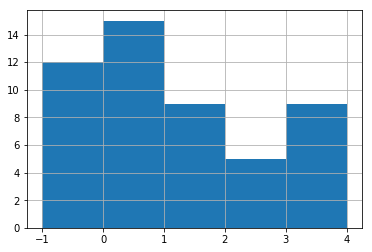

In [8]:
df['score'].hist(bins=range(-1,5))

In [9]:
# Now generate the ground truth "eaten"
# For teaching purposes, we need two things to be true:
#  - We want the predictor to be good but not perfect. So we base `eaten` on `score`
#    so that the score is calibrated, like a properly trained model.
#  - There is an imblance between fruit and veg. This will come automatically because 
#    we have imbalanced the feature distributions, so the score is unbalanced
# 

# Being able to map the scores to monotonic probabilities makes the classifier "calibrated"
score_probabilities = {
    -1: 0.1,
    0:  0.25,
    1:  0.5,
    2:  0.75,
    3:  0.9
}

df['eaten'] = df['score'].apply(lambda score: random.uniform() <= score_probabilities[score])


In [10]:
pd.crosstab(df.eaten, df.score)

score,-1,0,1,2,3
eaten,,,,,
False,10,12,3,1,0
True,2,3,6,4,9


In [11]:
pd.crosstab(df.truth, df.eaten)

eaten,False,True
truth,,
fruit,9,16
veg,17,8


In [12]:
# We can now turn this score into a classifier by thresholding at some value
thresh = 1
df['predicted'] =  df.score >= thresh

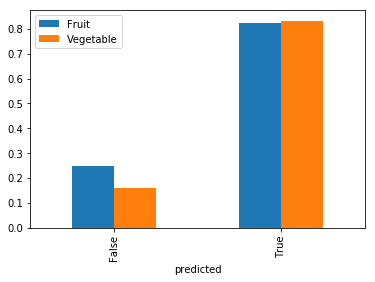

In [13]:
# Is this classifier balanced?
f = df[df.truth=='fruit'].groupby('predicted').mean()['eaten']
v = df[df.truth=='veg'].groupby('predicted').mean()['eaten']

# We can actually look at the calibration now
a = pd.concat([f,v], axis=1)
a.columns = ['Fruit','Vegetable']
a.plot.bar()

We can get six different classifiers by setting our score threshold from < -1 to > 3. But < -1 is always predict eaten and >3 is always predict not eaten, so there are really only four thresholds that make sense. Let's see the confusion matrix for one of these levels.

In [14]:
# cm is a confusion matrix. The rows are guessed, the columns are actual 
def print_ppv_fpv(cm):
    # the indices here are [col][row] or [actual][guessed]
    TN = cm[False][False]   
    TP = cm[True][True]
    FN = cm[True][False]
    FP = cm[False][True]
    print('Accuracy: ', (TN+TP)/(TN+TP+FN+FP))
    print('PPV: ', TP / (TP + FP))
    print('FPR: ', FP / (FP + TN))
    print('FNR: ', FN / (FN + TP))
    print()

def print_metrics(guessed, actual):
    cm = pd.crosstab(guessed, actual, rownames=['guessed'], colnames=['actual'])
    print(cm)
    print()
    print_ppv_fpv(cm)    


In [15]:
print('Everyone')
print_metrics(df.predicted, df.eaten)

print('Fruits')
subset = df[df.truth == 'fruit']
print_metrics(subset.predicted, subset.eaten)

print('Vegetables')
subset = df[df.truth == 'veg']
print_metrics(subset.predicted, subset.eaten)

Everyone
actual   False  True 
guessed              
False       22      5
True         4     19

Accuracy:  0.82
PPV:  0.826086956522
FPR:  0.153846153846
FNR:  0.208333333333

Fruits
actual   False  True 
guessed              
False        6      2
True         3     14

Accuracy:  0.8
PPV:  0.823529411765
FPR:  0.333333333333
FNR:  0.125

Vegetables
actual   False  True 
guessed              
False       16      3
True         1      5

Accuracy:  0.84
PPV:  0.833333333333
FPR:  0.0588235294118
FNR:  0.375



In [16]:
# Cleanup and save
df = df.rename(index=str, columns={"truth": "fruit_or_veg", "fruit": "name"})
df = df[['name','fruit_or_veg','exotic','in_season','imported','score','eaten']]
df.head()

,name,fruit_or_veg,exotic,in_season,imported,score,eaten
0,apple,fruit,False,True,True,0,False
1,apricot,fruit,True,True,False,3,True
2,banana,fruit,False,True,False,1,True
3,blueberry,fruit,False,True,False,1,True
4,blackberry,fruit,True,False,False,2,True


In [17]:
df.to_csv('kitchen-confusion-matrix.csv')